# Skin Cancer Detection using CNN

Cancer is a disease in which cells are developed abnormally and they divide uncontrollably. This in turn has the ability to infiltrate and destroy normal body tissue. Skin cancer is by far the most common type of cancer. If detected early, it is highly treatable.

Deep learning in the field of image processing has shown exceptional results. The aim of this project is to do skin cancer detection using Convolutional Neural Networks (CNN) and transfer learning. The goal is to create such a model that it can detect from a scan if the cancer is benign or malignant, so that it is detected and appropriate medical treatment can be provided for its cure.

TensorFlow library is used for the deep learning. Xception Convolutional Neural Network (CNN) is used.

### Importing the libraries

The required libraries are imported.

In [1]:
# import libraries
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Lambda, Dropout, Activation, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
import pandas as pd
import plotly.express as px

### Creating the directories for Kaggle

Directories for train, test and output folders are created.

The image dimension is also set for 299 pixels based upon the data.

In [3]:
trainFolder = "../input/skin-cancer-malignant-vs-benign/train/"
testFolder = "../input/skin-cancer-malignant-vs-benign/test/"
outputDir = "/kaggle/working/"
imgDim = 299

### Generalized Mean Pooling

Generalized Mean Pooling computes the generalized mean of each channel of a tensor. It helps focus on the salient features of the image.

In [4]:
gm_exp = tf.Variable(3., dtype=tf.float32)
def generalized_mean_pool_2d(X):
    pool = (tf.reduce_mean(tf.abs(X**(gm_exp)), 
                           axis=[1,2], 
                           keepdims=False)+1.e-8)**(1./gm_exp)
    return pool


### Base Model

We have defined a function "getBaseModel" that takes "freezedLayers" as attributes and those number of layers are freezed in the "Xception" CNN for transfer learning. The property "layer.trainable" is set as "False" for the layers that we want to freeze.

In [ ]:
def getBaseModel(freezedLayers):
    model = Xception(input_shape=(imgDim,imgDim,3),weights='imagenet',include_top=False)
    for layer in model.layers:
        layer.trainable = True
    for layer in model.layers[:freezedLayers]:
        layer.trainable = False   
    return model

### Additional Layers

A function "getAttachmentForModel" is defined in which The additional layers are defined for training i.e., 3 hidden (dropout, activation and dense) layers and 1 output layer.

In [ ]:
def getAttachmentForModel(model):
    X_feat = Input(model.output_shape[1:])
    lambda_layer = Lambda(generalized_mean_pool_2d)
    lambda_layer.trainable_weights.extend([gm_exp])
    X = lambda_layer(X_feat)
    X = Dropout(0.05)(X)
    X = Activation('relu')(X)
    X = Dense(2, activation='softmax')(X)
    return Model(inputs=X_feat, outputs=X)

### Final Model

The "getFinalModel" function takes the base model as input and creates a model with the freezed layers as well as the new layers that are required for the training of the model.

In [ ]:
def getFinalModel(baseModel):
    attachment = getAttachmentForModel(baseModel)
    imageInput = Input((299,299,3))
    finalModel = baseModel(imageInput)
    finalModel = attachment(finalModel)
    finalModel = Model(inputs=imageInput, outputs=finalModel)
    return finalModel

### Save History

The "saveHistoryFile" fuction saves the history including the accuracy for each epoch into a csv file. This can be used later on for visualizations and drawing conclusions.

In [5]:
def saveHistoryFile(freezedLayers,model):
    df = pd.DataFrame(model.history)
    with open(f'{outputDir}{freezedLayers}.json','w') as f:
        df.index.name = "Epoch"
        df["freezed_layer"] = f"{freezedLayers}"
        df.to_csv(f)


### Image Augmentation

This is a technique that is used to expand the dataset artificially. We have set the attributes of "rescale" to 1/255, "shear_range" to 0.2, "zoon_range" to 0.2 and "horizontal_flip" as True for both train dataset as well as test dataset.

We have defined the train and test folders, targert_size as 299 pixels by 299 pixels, batch_size as 48 images and class_mode as "categorical" for both train and test dataset.

In [6]:
trainGenerator = ImageDataGenerator(
    rescale = 1./255,                                     
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True)

testGenerator = ImageDataGenerator(rescale = 1./255)

trainData = trainGenerator.flow_from_directory(
    trainFolder,
    target_size = (299, 299),
    batch_size = 48,
    class_mode = 'categorical')

testData = testGenerator.flow_from_directory(
    testFolder, 
    target_size = (299, 299),
    batch_size = 48, 
    class_mode = 'categorical')


Found 2637 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


### Train the Model

Now, we are training the model. Xception CNN model has 132 layers, therefore, we are starting from 130 freezed layers and going down to 85 layers with the difference of 5 layers each time to reach the optimum result in which we have the best results.

The loss function used is "categorical_crossentropy" and the optimized is "adam".

In [7]:
for i in range(130,84,-5):
    print(f"Using {i} freezed layers")
    freezedLayers = i
    finalModel = getFinalModel(getBaseModel(freezedLayers))
    finalModel.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=[
            'binary_accuracy', 
            'AUC',
            tf.keras.metrics.TruePositives(name='true_positives'),
            tf.keras.metrics.TrueNegatives(name='true_negatives'),
            tf.keras.metrics.FalsePositives(name='false_positives'),
            tf.keras.metrics.FalseNegatives(name='false_negatives'),
        ]
    )
    trainedModel = finalModel.fit_generator(
        trainData,
        validation_data=testData,
        epochs=10,
    )
    saveHistoryFile(freezedLayers,trainedModel)

Using 130 freezed layers
83683744/83683744 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/10
55/55 [==============================] - 97s 2s/step - loss: 0.5346 - binary_accuracy: 0.7436 - auc: 0.8153 - true_positives: 1961.0000 - true_negatives: 1961.0000 - false_positives: 676.0000 - false_negatives: 676.0000 - val_loss: 0.5639 - val_binary_accuracy: 0.7152 - val_auc: 0.8033 - val_true_positives: 472.0000 - val_true_negatives: 472.0000 - val_false_positives: 188.0000 - val_false_negatives: 188.0000
Epoch 2/10
55/55 [==============================] - 70s 1s/step - loss: 0.4287 - binary_accuracy: 0.8005 - auc: 0.8841 - true_positives: 2111.0000 - true_negatives: 2111.0000 - false_positives: 526.0000 - false_negatives: 526.0000 - val_loss: 0.4246 - val_binary_accuracy: 0.7879 - val_auc: 0.8842 - val_true_positives: 520.0000 - val_true_negatives: 520.0000 - val_false_positives: 140.0000 - val_false_negatives: 140.0000
Epoch 3/10
55/55 [==============================] - 70s 1s/step - loss: 0.3941 - binary_accuracy: 0.8138 - auc: 0.9027 - true_positives: 2146.0000 - tru

# Visualizing the Findings

Firstly, we will be loading the data from the csv file into a DataFrame.

In [3]:
def getData():
    df = pd.read_csv('./all.csv')
    df['Trainable Layers'] = 132 - df['freezed_layer']
    return df

Plotting the Validation loss vs freezed layers. We observe that as we increase the amount of freezed layers, the loss also increases.

In [16]:
df = getData()
df = df[df.Epoch == 9]
fig = px.line(
    df, 
    x=df['freezed_layer'], 
    y=df['val_loss'],
    title="Plotting Loss vs Freezed Layers",
).update_layout(xaxis_title="Number Of Freezed Layers", yaxis_title="Loss",yaxis_range=[0.0,1.0])
fig.show()

Plotting the Validation Accuracy vs freezed layers. We observe that as we increase the amount of freezed layers, the accuracy also decreases.

In [19]:
df = getData()
df = df[df.Epoch == 9]
fig = px.line(
    df, 
    x=df['freezed_layer'], 
    y=df['val_binary_accuracy'],
    title="Plotting Accuracy vs Freezed Layers",
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy",yaxis_range=[0.7,1.0])
fig.show()

Plotting accuracy and loss for the best optimum results achieved and that is for the freezed layers = 90 with the Validation Accuracy = 0.881818175315856 and the Validation Loss = 0.417837142944335. We can conclude that as we increase the epochs, our acuracy increases and the loass decreases.

In [14]:
df = getData()
df = df[df.freezed_layer == 90]
fig = px.line(
    df, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 90)"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

Plotting accuracy and loss for the worst results achieved and that is for the freezed layers = 125 with the Accuracy = 0.818181812763214 and the Loss = 0.480963498353958. Although, as the epochs are increased the accuracy and loss and increasing and decreaseing respectively, we have achieved optimum results with freezed layers = 90.

In [21]:
df = getData()
df = df[df.freezed_layer == 125]
fig = px.line(
    df, 
    x='Epoch', 
    y=['val_loss','val_binary_accuracy'],
    title="Validation Accuracy & Loss (Freezed Layers = 125)"
).update_layout(xaxis_title="Number of Freezed Layers", yaxis_title="Accuracy")
fig.show()

# Summary

The summary of our findings can be shown as below:

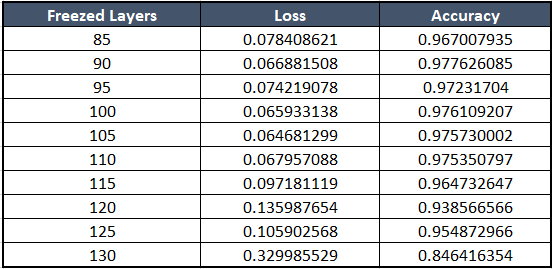

The column "Freezed Layers" signifies that how many layers were freezed for the training. The columns "Loss" and "Accuracy" signifies the loss and accuracy for those approaches.

##### Based upon our findings, we conclude that the best optimum results can be achieved with 90 freezed layers with Accuracy = 0.977626085281372 and Loss = 0.0668815076351165.

# Future Scope

The future scope involves training for more epochs, however, that would require more computational power and we can explore that option if given more time.

Moreover, different trained CNN model aprt from Xception can be used to achieve better results for this application.

Furthermore, this application can be deployed to test and eventually production environment if it passes all the necessary approvals and compliances.

# References

1. https://www.kaggle.com/code/danushkumarv/skin-cancer-detection-deep-cnn/notebook This notebook is used for the code guidance and as a baseline configuration.

2. https://www.kaggle.com/datasets/fanconic/skin-cancer-malignant-vs-benign Dataset for skin cancer detection was used from here.